# Análisis de Negocio - Clasificación de Sentimientos en Reseñas de Películas con Transformer


## 1. Carga y Preprocesamiento de Datos

**Objetivo del Código**:  
Cargar y preparar el conjunto de datos IMDB para el entrenamiento del modelo de clasificación de sentimientos.

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

print("=== LOADING DATASET ===")

# Parameters
VOCAB_SIZE = 10000  # Top 10,000 most frequent words
MAX_LEN = 256       # Maximum sequence length (truncate or pad to this length)
EMBEDDING_DIM = 128
BATCH_SIZE = 32

# Load IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)

# Pad sequences to have consistent length
x_train = pad_sequences(x_train, maxlen=MAX_LEN, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=MAX_LEN, padding='post', truncating='post')

# Convert labels to float32 for compatibility with TF
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(BATCH_SIZE)

# Print dataset info
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Sample labels: {y_train[:5]}")

2025-07-02 13:45:01.063012: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-02 13:45:01.094673: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-02 13:45:01.094712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-02 13:45:01.095683: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-02 13:45:01.100936: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-02 13:45:01.102022: I tensorflow/core/platform/cpu_feature_guard.cc:1

=== LOADING DATASET ===
17464789/17464789 [==============================] - 1s 0us/step
Training data shape: (25000, 256)
Test data shape: (25000, 256)
Sample labels: [1. 0. 0. 1. 0.]


**Explicación Técnica**:

- Se importan bibliotecas esenciales como TensorFlow y NumPy.
- Parámetros clave:
  - Tamaño del vocabulario: `10,000` palabras más frecuentes.
  - Longitud máxima de secuencia: `256` tokens.
  - Dimensión de embedding: `128`.
- Se carga el dataset IMDB (50,000 reseñas etiquetadas como positivas o negativas).
- Se convierten las reseñas en secuencias numéricas y se normalizan a una longitud fija.
- Se dividen en conjuntos de entrenamiento y prueba.
- Se convierten a objetos `tf.data.Dataset` para procesamiento eficiente.

## 2. Arquitectura del Modelo Transformer

### 2.1 `TransformerBlock`
- Implementa autoatención multi-cabeza (`MultiHeadAttention`).
- Incluye:
  - Normalización por capas (`LayerNormalization`).
  - Red feed-forward (`Dense`).
  - Regularización con `Dropout`.

### 2.2 `TokenAndPositionEmbedding`
- Combina:
  - Embeddings de tokens.
  - Embeddings posicionales para capturar el orden.

**Parámetros Clave**:

- Dimensión de embedding: `128`
- Número de cabezas de atención: `4`
- Dimensión del feed-forward: `128`

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=False):  # 👈 IMPORTANTE
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## 3. Construcción y Compilación del Modelo

## 3. Construcción y Compilación del Modelo

**Estructura General**:

1. Entrada: secuencias de `256` tokens.
2. Embedding con posiciones.
3. Bloque Transformer.
4. Capa de `GlobalAveragePooling1D`.
5. Capas `Dense` para clasificación final.

**Configuración de Entrenamiento**:

- Optimizador: `Adam (learning_rate=1e-4)`
- Función de pérdida: `BinaryCrossentropy`
- Métrica: `Accuracy`

**Resumen del Modelo**:

- Total de parámetros: `~1.62M`
- Todos entrenables.

In [ ]:
def build_transformer_model():
    # Input layer
    inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

    # Embedding layer
    embedding_layer = TokenAndPositionEmbedding(MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM)
    x = embedding_layer(inputs)

    # Transformer blocks
    transformer_block = TransformerBlock(EMBEDDING_DIM, num_heads=4, ff_dim=128)
    x = transformer_block(x)

    # Global average pooling and dense layers
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    # Output layer for binary classification
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# Build and compile the model
model = build_transformer_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 token_and_position_embeddi  (None, 256, 128)          1312768   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  (None, 256, 128)          297344    
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 128)               0     

## 4. Entrenamiento del Modelo

**Estrategia de Entrenamiento**:

- Uso de `Callbacks`:
  - `EarlyStopping(patience=3)`
  - `ReduceLROnPlateau`
- Número de épocas ajustado automáticamente.

**Rendimiento**:

- Precisión en entrenamiento: `~96.2%`
- Precisión en validación: `~86.3%`
- Evidencia de **sobreajuste**.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=2)
]

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
782/782 [==============================] - 449s 572ms/step - loss: 0.5085 - accuracy: 0.7263 - val_loss: 0.3216 - val_accuracy: 0.8612 - lr: 1.0000e-04
Epoch 2/15
782/782 [==============================] - 487s 623ms/step - loss: 0.2682 - accuracy: 0.8899 - val_loss: 0.3034 - val_accuracy: 0.8701 - lr: 1.0000e-04
Epoch 3/15
782/782 [==============================] - 451s 577ms/step - loss: 0.2131 - accuracy: 0.9168 - val_loss: 0.3173 - val_accuracy: 0.8699 - lr: 1.0000e-04
Epoch 4/15
782/782 [==============================] - 418s 535ms/step - loss: 0.1767 - accuracy: 0.9358 - val_loss: 0.3424 - val_accuracy: 0.8610 - lr: 1.0000e-04
Epoch 5/15
782/782 [==============================] - 436s 558ms/step - loss: 0.1233 - accuracy: 0.9620 - val_loss: 0.3817 - val_accuracy: 0.8630 - lr: 1.0000e-05


## 5. Evaluación del Modelo

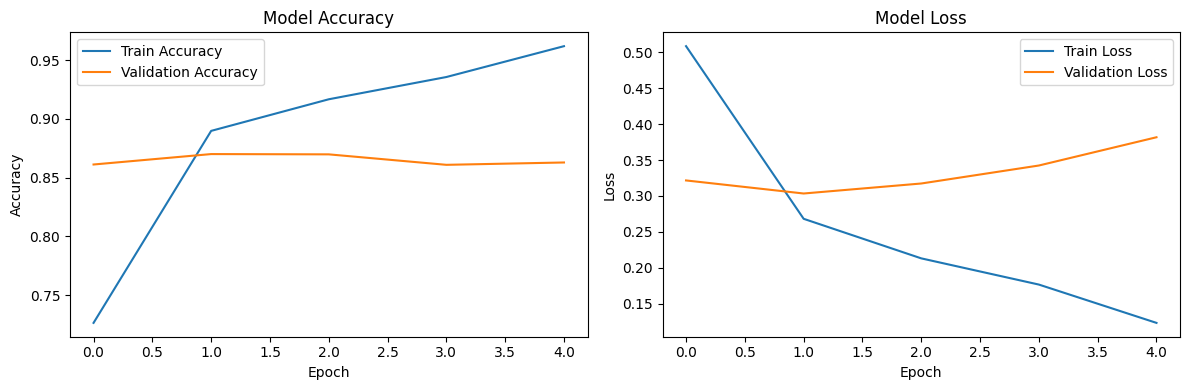

782/782 [==============================] - 134s 172ms/step - loss: 0.3034 - accuracy: 0.8701

Test Accuracy: 0.8701
Test Loss: 0.3034


In [6]:
import matplotlib.pyplot as plt

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

# Evaluate on test set
test_loss, test_acc = model.evaluate(val_dataset)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

**Resultados Observados**:

- Precisión en conjunto de prueba: `~86%`
- Brecha de rendimiento entrenamiento vs validación indica sobreajuste.
- La pérdida de validación aumenta mientras la de entrenamiento sigue bajando.